<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e;'>📑 Styling, Links and Modules</h1>

---

#### [🌐 tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras)
#### [🌐 The Data Set of Flower Images (R)](https://www.kaggle.com/olgabelitskaya/the-data-set-of-flower-images-r) & [🌐 Github Repository](https://github.com/OlgaBelitskaya/deep_learning_projects/tree/master/DL_PP0) & [🌐 Google Colaboratory Version](https://colab.research.google.com/drive/1H2ArWH_1kYfkIoCbxleX-aHAozRVBAdB)

### 掛載檔案

In [18]:
# 下載 file_id 為 "1duQU7xqXRsOSPYeOR0zLiSA8g_LCFzoV" 的檔案，並將它命名為 Minori.jpg
!gdown --id '1R_Tdx0iJFbCIn3nf8JZLaqFwSD2ZU9AM' --output sticker-images.zip
# 列出目前目錄下所有的檔案
!ls

import os
import zipfile
os.chdir("/content")
root = os.getcwd()
ldir = os.listdir()
target = "sticker-images.zip"
targetF= "sticker-images"
path = str(root) + "/" + target
location = str(root) + "/" + targetF
print(ldir)

try:
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(location)
    print("成功!!")
    !ls -l

except Exception as e:
    print(f"(\n{e}\n)")
    print("失敗...")

Downloading...
From: https://drive.google.com/uc?id=1R_Tdx0iJFbCIn3nf8JZLaqFwSD2ZU9AM
To: /content/sticker-images.zip
34.0MB [00:00, 207MB/s]
drive  sample_data  sticker-images  sticker-images.zip
['.config', 'sticker-images', 'drive', '.ipynb_checkpoints', 'sticker-images.zip', 'sample_data']
成功!!
total 33204
drwx------ 5 root root     4096 Jan 17 15:33 drive
drwxr-xr-x 1 root root     4096 Jan  6 18:10 sample_data
drwxr-xr-x 4 root root     4096 Jan 17 16:16 sticker-images
-rw-r--r-- 1 root root 33987263 Jan 17 16:16 sticker-images.zip


In [ ]:
import warnings; warnings.filterwarnings('ignore')
import tensorflow as tf,seaborn as sn,pylab as pl
import os,h5py,cv2,pandas as pd,numpy as np
from tensorflow import keras as tk
import keras.preprocessing.image as tkimg
from keras.callbacks import \
ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import \
BatchNormalization,Conv2D,Dense,\
LSTM,Flatten,Activation,Dropout,MaxPooling2D,\
GlobalMaxPooling2D,GlobalAveragePooling2D
from keras.layers.advanced_activations \
import PReLU,LeakyReLU

# 記得在 Google Drive 中的路徑後面 加上 / 斜線
fpaths='/content/drive/MyDrive/DeepLearning/sticker-images/sticker_images/'
fpaths2='/content/drive/MyDrive/DeepLearning/sticker-images/'
fweights='/content/drive/MyDrive/DeepLearning/sticker-images/checkpoints/'

fpaths='/content/sticker-images/sticker_images/'
fpaths2='/content/sticker-images/'
fweights='/content/sticker-images/checkpoints/'

print(f"fpaths\t\t = {fpaths}")
print(f"fpaths2\t\t = {fpaths2}")
print(f"fweights\t = {fweights}")

print('tensorflow version:',tf.__version__)

fpaths		 = /content/drive/MyDrive/DeepLearning/sticker-images/sticker_images/
fpaths2		 = /content/drive/MyDrive/DeepLearning/sticker-images/
fweights	 = /content/drive/MyDrive/DeepLearning/sticker-images/checkpoints/
tensorflow version: 2.4.0


In [ ]:
def images2array(files_path,img_size,grayscale=False):
    files_list=sorted(os.listdir(files_path))
    n,img_array=len(files_list),[]
    for i in range(n):
        if i%round(.1*n)==0:
            print('=>',end='',flush=True)
        img_path=files_path+files_list[i]
        if (img_path[-4:]=='.png'):
            img=tkimg.load_img(
                img_path,grayscale=grayscale,
                target_size=(img_size,img_size))
        img=tkimg.img_to_array(np.squeeze(img))
        img=np.expand_dims(img,axis=0)/255
        img_array.append(img)
    return np.array(np.vstack(img_array),dtype='float32')
def keras_history_plot(fit_history,fig_size,color='#ff355e'):
    keys=list(fit_history.history.keys())
    list_history=[fit_history.history[keys[i]] 
                  for i in range(len(keys))]
    dfkeys=pd.DataFrame(list_history).T
    dfkeys.columns=keys
    fig=pl.figure(figsize=(fig_size,fig_size))
    ax1=fig.add_subplot(2,1,1)
    dfkeys.iloc[:,[0,2]].plot(
        ax=ax1,color=['slategray',color],grid=True)
    ax2=fig.add_subplot(2,1,2)
    dfkeys.iloc[:,[1,3]].plot(
        ax=ax2,color=['slategray',color],grid=True)
    pl.tight_layout(); pl.show()

# <h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e;'>📑 Data Exploration</h1>

In [ ]:
##################
# !!!! 警告 !!!! #
##################

# 照片總數 1368 #

# Colab 讀取照片 費時 13 分鐘 #
############################

# 讀取 圖片 路徑fpaths 與 lables.csv 在同一個資料夾!
flowers=pd.read_csv(fpaths+'sticker_labels.csv')
files=flowers['file']
labels=np.array(flowers['label'].values,dtype='int32')
# 0 = capo, 1 = LINE, 2 = Kanahei, 3 = peach_cat, 4 = bad_cat,
# 5 = Shiba_Inu_dog, 6 = eggplant_brother, 7 = fat_shark
names=['capo','LINE','Kanahei','peach_cat',
       'bad_cat','Shiba_Inu_dog','eggplant_brother','fat_shark']
img_size=128
images=images2array(fpaths,img_size)
# with h5py.File(fpaths2+'Sticker_Color_Images.h5','r') as f:
#     images2=f['images'].value
#     labels2=f['labels'].value

=>=>=>=>=>=>=>=>=>=>

In [ ]:
N=labels.shape[0]; n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)

images,labels=images[shuffle_ids],labels[shuffle_ids]

# X = images
x_test,x_valid,x_train=\
images[:n],images[n:2*n],images[2*n:]

# Y = labels
y_test,y_valid,y_train=\
labels[:n],labels[n:2*n],labels[2*n:]

df=pd.DataFrame(
    [[x_train.shape,x_valid.shape,x_test.shape],
     [x_train.dtype,x_valid.dtype,x_test.dtype],
     [y_train.shape,y_valid.shape,y_test.shape],
     [y_train.dtype,y_valid.dtype,y_test.dtype]],
    columns=['train','valid','test'],
    index=['X_image shape','X_image type',
           'Y_label shape','Y_label type'])
df

,train,valid,test
X_image shape,"(1096, 128, 128, 3)","(136, 128, 128, 3)","(136, 128, 128, 3)"
X_image type,float32,float32,float32
Y_label shape,"(1096,)","(136,)","(136,)"
Y_label type,int32,int32,int32


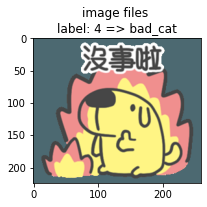

In [ ]:
n=np.random.randint(0,210,1)[0]
ti='image files \nlabel: %d => '\
%labels[n]+names[labels[n]]
img=cv2.imread(fpaths+files[n])
rgb_img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
pl.figure(figsize=(3,3))
pl.imshow(rgb_img); pl.title(ti);

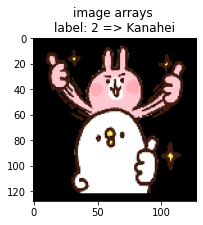

In [ ]:
n=np.random.randint(0,167,1)[0]
ti='image arrays \nlabel: %d => '\
%y_train[n]+names[y_train[n]]
pl.figure(figsize=(3,3))
pl.imshow((x_train[n])); pl.title(ti);

<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e;'>📑 Classification Models</h1>

## MPL Model

In [ ]:
def mlp_model():
    model=Sequential()    
    model.add(Dense(
        128,activation='relu',input_shape=(img_size**2*3,)))
    model.add(BatchNormalization())    
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())    
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())   
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(.2))     
    model.add(Dense(8,activation='softmax'))
    model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')
    return model
mlp_model=mlp_model()
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               6291584   
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              5

In [ ]:
early_stopping=EarlyStopping(
    monitor='val_loss',patience=20,verbose=2)
checkpointer=ModelCheckpoint(
    filepath=fweights,save_best_only=True,verbose=2,
    save_weights_only=True,monitor='val_acc',mode='max')
lr_reduction=ReduceLROnPlateau(
    monitor='val_loss',verbose=2,patience=5,factor=.8)
mhistory=mlp_model.fit(
    x_train.reshape(-1,img_size**2*3),y_train,
    epochs=100,batch_size=64,verbose=2,
    validation_data=(x_valid.reshape(-1,img_size**2*3),y_valid),
    callbacks=[checkpointer,early_stopping,lr_reduction])

Epoch 1/100
18/18 - 2s - loss: 1.2654 - accuracy: 0.5703 - val_loss: 4.2949 - val_accuracy: 0.3971
Epoch 2/100
18/18 - 0s - loss: 0.7432 - accuracy: 0.7509 - val_loss: 3.2955 - val_accuracy: 0.3382
Epoch 3/100
18/18 - 0s - loss: 0.5256 - accuracy: 0.8020 - val_loss: 2.8507 - val_accuracy: 0.3676
Epoch 4/100
18/18 - 0s - loss: 0.3923 - accuracy: 0.8659 - val_loss: 2.6446 - val_accuracy: 0.4044
Epoch 5/100
18/18 - 0s - loss: 0.2554 - accuracy: 0.9197 - val_loss: 1.5213 - val_accuracy: 0.5294
Epoch 6/100
18/18 - 0s - loss: 0.3848 - accuracy: 0.8659 - val_loss: 1.4552 - val_accuracy: 0.5515
Epoch 7/100
18/18 - 0s - loss: 0.2247 - accuracy: 0.9279 - val_loss: 1.1686 - val_accuracy: 0.6029
Epoch 8/100
18/18 - 0s - loss: 0.2437 - accuracy: 0.9215 - val_loss: 2.1159 - val_accuracy: 0.5000
Epoch 9/100
18/18 - 0s - loss: 0.2438 - accuracy: 0.9224 - val_loss: 2.2076 - val_accuracy: 0.5147
Epoch 10/100
18/18 - 0s - loss: 0.3645 - accuracy: 0.9005 - val_loss: 2.8799 - val_accuracy: 0.4412
Epoch 11/

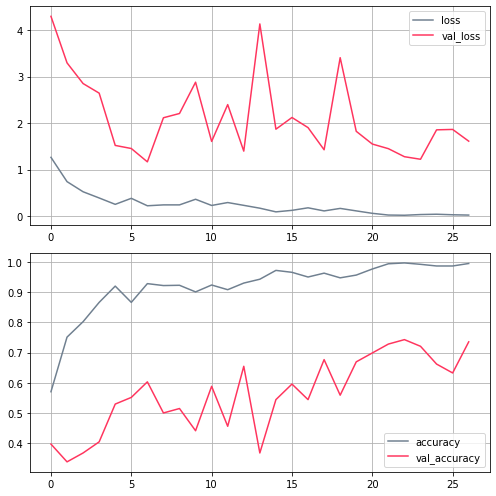

x_test  = 1.8014438152313232
y_test  = 0.6470588445663452


In [ ]:
keras_history_plot(mhistory,7)
# mlp_model.load_weights(fweights)
ans1, ans2 = mlp_model.evaluate(
    x_test.reshape(-1,img_size**2*3),y_test,verbose=0)
print(f"x_test  = {ans1}")
print(f"y_test  = {ans2}")


## CNN Model

In [ ]:
def cnn_model():
    model=Sequential()
    model.add(Conv2D(32,(5,5),padding='same',
                     input_shape=(img_size,img_size,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))
    model.add(Conv2D(96,(5,5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))
    model.add(GlobalAveragePooling2D())    
    model.add(Dense(512,activation='tanh'))
    model.add(Dropout(.25))     
#    model.add(Dense(256,activation='tanh'))
#    model.add(Dropout(.25))     
    model.add(Dense(128,activation='tanh'))
    model.add(Dropout(.25)) 
    model.add(Dense(8))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])    
    return model
cnn_model=cnn_model()
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 96)        76896     
_________________________________________________________________
activation_1 (Activation)    (None, 60, 60, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 96)       

In [ ]:
early_stopping=EarlyStopping(
    monitor='val_loss',patience=20,verbose=2)
checkpointer=ModelCheckpoint(
    filepath=fweights,save_best_only=True,verbose=2,
    save_weights_only=True,monitor='val_acc',mode='max')
lr_reduction=ReduceLROnPlateau(
    monitor='val_loss',verbose=2,patience=5,factor=.8)
chistory=cnn_model.fit(
    x_train,y_train,epochs=100,batch_size=16,
    verbose=2,validation_data=(x_valid,y_valid),
    callbacks=[checkpointer,early_stopping,lr_reduction])

Epoch 1/100
69/69 - 7s - loss: 1.5778 - accuracy: 0.3923 - val_loss: 1.3247 - val_accuracy: 0.5294
Epoch 2/100
69/69 - 1s - loss: 1.1379 - accuracy: 0.5438 - val_loss: 0.9483 - val_accuracy: 0.6103
Epoch 3/100
69/69 - 1s - loss: 0.9332 - accuracy: 0.6268 - val_loss: 0.8825 - val_accuracy: 0.6912
Epoch 4/100
69/69 - 1s - loss: 0.7687 - accuracy: 0.7181 - val_loss: 0.7855 - val_accuracy: 0.7574
Epoch 5/100
69/69 - 1s - loss: 0.7016 - accuracy: 0.7381 - val_loss: 0.6558 - val_accuracy: 0.7500
Epoch 6/100
69/69 - 1s - loss: 0.6385 - accuracy: 0.7728 - val_loss: 1.1706 - val_accuracy: 0.6544
Epoch 7/100
69/69 - 1s - loss: 0.5814 - accuracy: 0.7938 - val_loss: 0.9279 - val_accuracy: 0.6618
Epoch 8/100
69/69 - 1s - loss: 0.5291 - accuracy: 0.8157 - val_loss: 0.4651 - val_accuracy: 0.8603
Epoch 9/100
69/69 - 1s - loss: 0.4873 - accuracy: 0.8358 - val_loss: 0.6195 - val_accuracy: 0.7941
Epoch 10/100
69/69 - 1s - loss: 0.4643 - accuracy: 0.8431 - val_loss: 0.5005 - val_accuracy: 0.8456
Epoch 11/

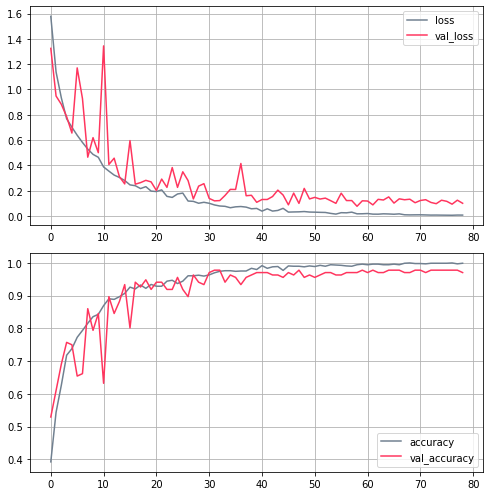

x_test  = 0.17816409468650818
y_test  = 0.970588207244873


In [ ]:
keras_history_plot(chistory,7)
# cnn_model.load_weights(fweights)
ans1, ans2 = cnn_model.evaluate(x_test,y_test,verbose=0)

print(f"x_test  = {ans1}")
print(f"y_test  = {ans2}")

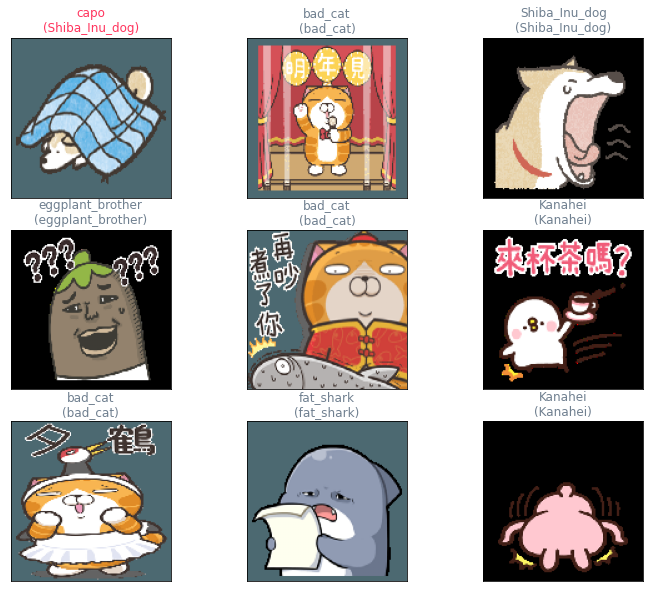

In [ ]:
py_test_cnn=cnn_model.predict_classes(x_test)
fig=pl.figure(figsize=(12,10))
randch=np.random.choice(
    x_test.shape[0],size=9,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(3,3,i+1,xticks=[],yticks=[])
    ax.imshow(x_test[idx])
    pred_idx=py_test_cnn[idx]
    true_idx=y_test[idx]
    ti='{}\n({})'.format(names[pred_idx],names[true_idx])
    ax.set_title(ti,color=(
        'slategray' if pred_idx==true_idx else '#ff355e'))
pl.show()

### Using **ImageDataGenerator**

In [ ]:
generator=tkimg.\
ImageDataGenerator(shear_range=.3,zoom_range=.3,
                   rotation_range=30,horizontal_flip=True)
ghistory=cnn_model.fit_generator(generator\
.flow(x_train,y_train,batch_size=16),\
steps_per_epoch=11,epochs=10,verbose=2,\
validation_data=(x_valid,y_valid),
callbacks=[checkpointer,early_stopping,lr_reduction])

Epoch 1/10
11/11 - 1s - loss: 0.1830 - accuracy: 0.9659 - val_loss: 0.1575 - val_accuracy: 0.9706
Epoch 2/10
11/11 - 1s - loss: 0.1335 - accuracy: 0.9489 - val_loss: 0.2043 - val_accuracy: 0.9412
Epoch 3/10
11/11 - 1s - loss: 0.0645 - accuracy: 0.9830 - val_loss: 0.1845 - val_accuracy: 0.9706
Epoch 4/10
11/11 - 1s - loss: 0.0289 - accuracy: 0.9886 - val_loss: 0.1510 - val_accuracy: 0.9706
Epoch 5/10
11/11 - 1s - loss: 0.0346 - accuracy: 0.9881 - val_loss: 0.2573 - val_accuracy: 0.9338
Epoch 6/10
11/11 - 1s - loss: 0.0977 - accuracy: 0.9773 - val_loss: 0.2019 - val_accuracy: 0.9632
Epoch 7/10
11/11 - 1s - loss: 0.0649 - accuracy: 0.9716 - val_loss: 0.2111 - val_accuracy: 0.9559
Epoch 8/10
11/11 - 1s - loss: 0.0376 - accuracy: 0.9830 - val_loss: 0.1594 - val_accuracy: 0.9632
Epoch 9/10
11/11 - 1s - loss: 0.0832 - accuracy: 0.9830 - val_loss: 0.1586 - val_accuracy: 0.9412

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010737419361248613.
Epoch 10/10
11/11 - 1s - loss: 0.041

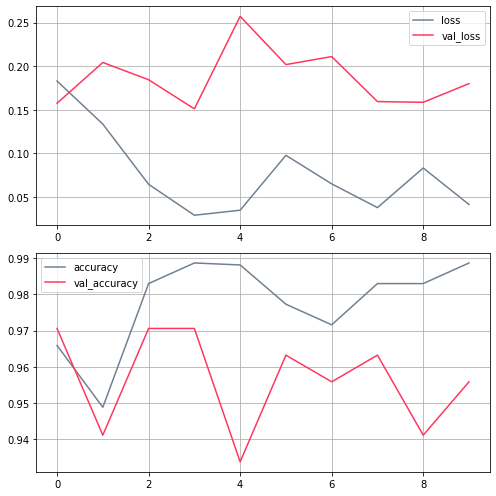

x_test  = 0.3494741916656494
y_test  = 0.9264705777168274


In [ ]:
keras_history_plot(ghistory,7)
# cnn_model.load_weights(fweights)
ans1, ans2 = cnn_model.evaluate(x_test,y_test,verbose=0)
print(f"x_test  = {ans1}")
print(f"y_test  = {ans2}")

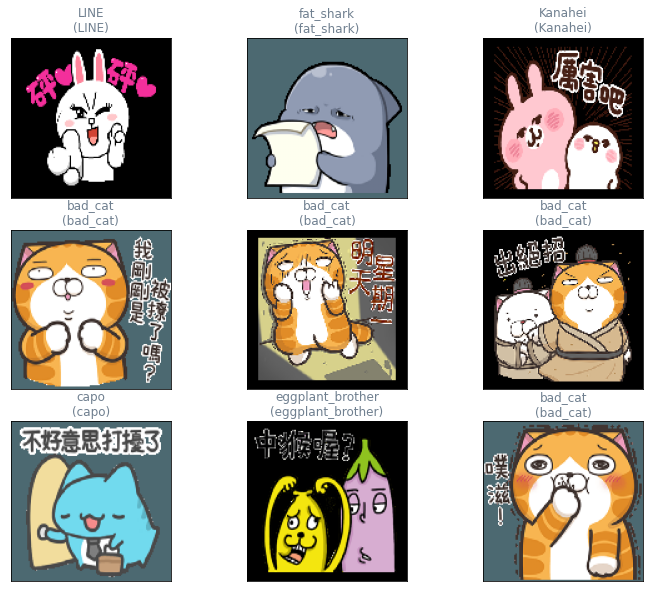

In [ ]:
py_test_cnn=cnn_model.predict_classes(x_test)
fig=pl.figure(figsize=(12,10))
randch=np.random.choice(
    x_test.shape[0],size=9,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(3,3,i+1,xticks=[],yticks=[])
    ax.imshow(x_test[idx])
    pred_idx=py_test_cnn[idx]
    true_idx=y_test[idx]
    ti='{}\n({})'.format(names[pred_idx],names[true_idx])
    ax.set_title(ti,color=(
        'slategray' if pred_idx==true_idx else '#ff355e'))
pl.show()

## RNN model

In [ ]:
def rnn_model():
    model=Sequential()
    model.add(LSTM(196,return_sequences=True,
                   input_shape=(1,img_size**2*3))) 
    model.add(LSTM(196,return_sequences=True))
    model.add(LSTM(196))  
    model.add(Dense(512,activation='relu'))
    model.add(Dense(8,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])    
    return model
rnn_model=rnn_model()
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 196)            38689616  
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 196)            308112    
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               308112    
_________________________________________________________________
dense_8 (Dense)              (None, 512)               100864    
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 4104      
Total params: 39,410,808
Trainable params: 39,410,808
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping=EarlyStopping(
    monitor='val_loss',patience=20,verbose=2)
checkpointer=ModelCheckpoint(
    filepath=fweights,save_best_only=True,verbose=2,
    save_weights_only=True,monitor='val_acc',mode='max')
lr_reduction=ReduceLROnPlateau(
    monitor='val_loss',verbose=2,patience=5,factor=.8)
rhistory=rnn_model.fit(
    x_train.reshape(-1,1,img_size**2*3),y_train,
    epochs=100,batch_size=64,verbose=2,
    validation_data=(x_valid.reshape(-1,1,img_size**2*3),y_valid),
    callbacks=[checkpointer,early_stopping,lr_reduction])

Epoch 1/100
18/18 - 5s - loss: 2.0042 - accuracy: 0.2564 - val_loss: 1.8918 - val_accuracy: 0.3088
Epoch 2/100
18/18 - 1s - loss: 1.7876 - accuracy: 0.3312 - val_loss: 1.5678 - val_accuracy: 0.3824
Epoch 3/100
18/18 - 1s - loss: 1.5922 - accuracy: 0.3786 - val_loss: 1.4786 - val_accuracy: 0.4265
Epoch 4/100
18/18 - 1s - loss: 1.5829 - accuracy: 0.3987 - val_loss: 1.5614 - val_accuracy: 0.3824
Epoch 5/100
18/18 - 1s - loss: 1.6238 - accuracy: 0.3650 - val_loss: 1.5562 - val_accuracy: 0.4338
Epoch 6/100
18/18 - 1s - loss: 1.6116 - accuracy: 0.3896 - val_loss: 1.5202 - val_accuracy: 0.4338
Epoch 7/100
18/18 - 1s - loss: 1.6111 - accuracy: 0.3859 - val_loss: 1.5543 - val_accuracy: 0.4338
Epoch 8/100
18/18 - 1s - loss: 1.6238 - accuracy: 0.3786 - val_loss: 1.6274 - val_accuracy: 0.4338

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 9/100
18/18 - 1s - loss: 1.6419 - accuracy: 0.3768 - val_loss: 1.5660 - val_accuracy: 0.4265
Epoch 10/100
18/18 - 1s - los

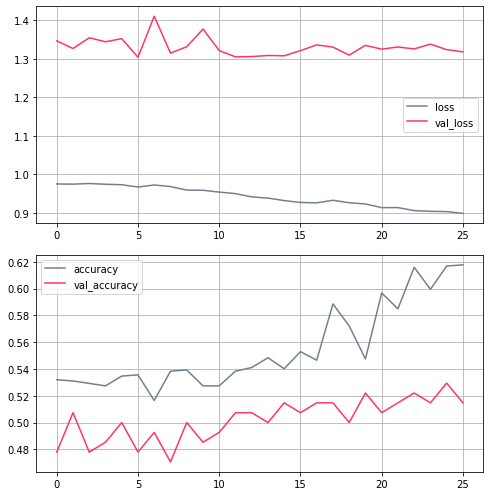

x_test  = 1.2973051071166992
y_test  = 0.5514705777168274


In [ ]:
keras_history_plot(rhistory,7)
# rnn_model.load_weights(fweights)
ans1, ans2 = rnn_model.evaluate(
    x_test.reshape(-1,1,img_size**2*3),y_test,verbose=0)
print(f"x_test  = {ans1}")
print(f"y_test  = {ans2}")
